In [22]:
import asyncio
import websockets
import json
import pandas as pd
import datetime as dt
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
nest_asyncio.apply()
from scipy import stats

import datetime
from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import skewnorm

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Strategy Outline
1. Short (lower strike) puts and (higher strike) calls
2. Strategy assumes vol will stay muted and we harvest theta yield over time
3. Find risk-neutral implied probabiltiies of option expiring in the money for the puts and calls
4. Short calls where the probability of the option expiring with price > chosen strike is less than 10% -15%
5. Short puts where the probability of the option expiring with price < chosen strike is less than 10%-15%
6. Stop-loss when floating loss on spread is 2 times more than premium to be earned at expiry
6. In essence, probability of stopping out per trade will be 20%-30% at initiation since could be 60% at the highest (at which point we will stop out)

In [23]:
hdata = HistData('ETH')
opt = Options("ETH")

## Options

## Get all active Eth options

### Get actively traded option chains

In [24]:
adjustment = 20
option_chain_call= opt.get_option_chain(pd.datetime.today(),option_type='call',date_adjustment=adjustment)
option_chain_put= opt.get_option_chain(pd.datetime.today(),option_type='put',date_adjustment =adjustment)
option_chain_call['scaled_iv'] = option_chain_call['mark_iv']*np.sqrt(option_chain_call['dte']/360)
option_chain_put['scaled_iv'] = option_chain_put['mark_iv']*np.sqrt(option_chain_put['dte']/360)

944 active options.
1713097628618
Expiration Date:  2024-04-26 16:00:00
944 active options.
1713097643593
Expiration Date:  2024-04-26 16:00:00


### Get Implied Probabilities
1. First method is to use the IV's themselves as the vol to calculate the implied probabilities
2. Second method is to use the atm strike's IV to calcualte the implied probabilities (Assumes a true normal distribution)

## Method 1

In [25]:

opt = Options('ETH')
curr_price = hdata.get_idx_price()
#curr_price
mu = 0.3
t = (option_chain_call['expiration_date'].iloc[0]-pd.datetime.today()).days/360
curr_price = curr_price * np.exp(mu*t)
curr_price

3543.08358964056

In [26]:
option_chain_call_adj=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put_adj=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put_adj,option_chain_call_adj])

1.0905351067869242


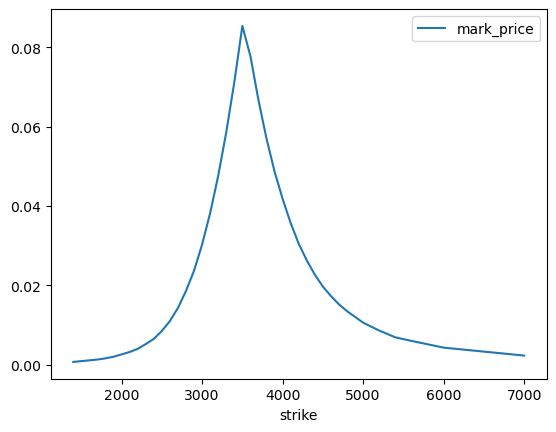

In [27]:
option_chain_full[['strike','mark_price']].set_index('strike').plot()
skewness = stats.skew(option_chain_full[['strike','mark_price']].set_index('strike'))[0]
print(skewness)

In [28]:
option_chain_full[['strike','mark_price']]

,strike,mark_price
0,1400.0,0.0007
0,1600.0,0.0011
0,1700.0,0.0013
0,1800.0,0.0016
0,1900.0,0.0020
0,2000.0,0.0026
0,2100.0,0.0032
0,2200.0,0.0040
0,2300.0,0.0052
0,2400.0,0.0065


<Axes: title={'center': 'Spread Steepness'}, xlabel='strike'>

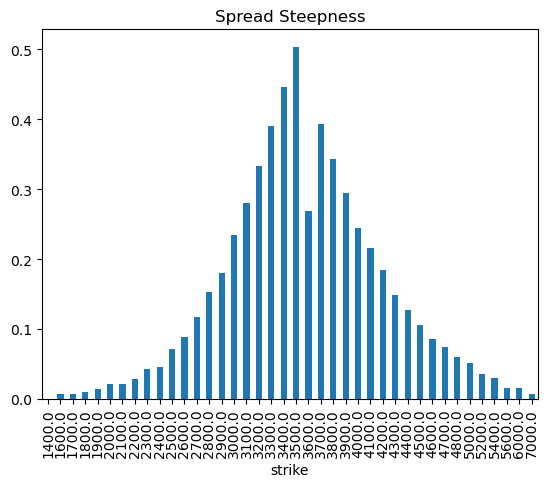

In [29]:
px_steepness=abs(option_chain_full['mark_price'].diff()*curr_price/option_chain_full['strike'].diff())
px_steepness.columns = ['spread_steepness']
px_steepness.index = option_chain_full['strike']
px_steepness.plot(kind='bar',title = 'Spread Steepness')
#We can use the put/call spread steepness to identify which legs command the highest premium to short

In [30]:
option_chain_call['implied_probability'] = 1-norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*option_chain_call['scaled_iv']/100)
option_chain_put['implied_probability'] = norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*option_chain_put['scaled_iv']/100)


option_chain_call=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put,option_chain_call])
option_chain_full['implied_probability'] = option_chain_full['implied_probability']*(0.5/option_chain_full['implied_probability'].max())

<Axes: title={'center': 'Option Implied Probabilities of ETH Expiration Price'}, xlabel='strike'>

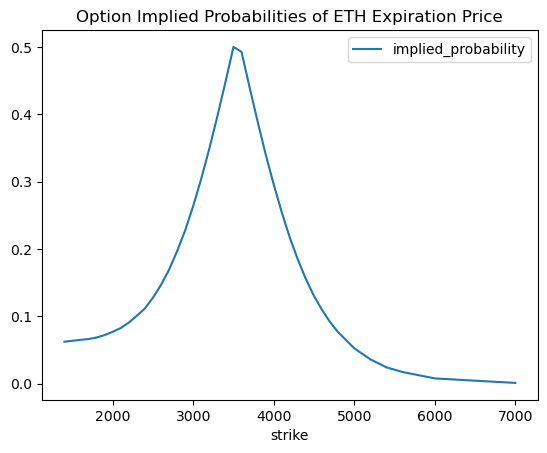

In [31]:
option_chain_full[['strike','implied_probability']].set_index('strike').plot(title='Option Implied Probabilities of ETH Expiration Price')

In [32]:
option_chain_full[['strike','implied_probability']]

,strike,implied_probability
0,1400.0,0.062252
0,1600.0,0.065100
0,1700.0,0.066268
0,1800.0,0.068549
0,1900.0,0.072176
0,2000.0,0.077023
0,2100.0,0.082644
0,2200.0,0.090690
0,2300.0,0.100877
0,2400.0,0.111683


## Method 2

In [28]:
option_chain_call= opt.get_option_chain(pd.datetime.today(),option_type='call')
option_chain_put= opt.get_option_chain(pd.datetime.today(),option_type='put')
option_chain_call['scaled_iv'] = option_chain_call['mark_iv']*np.sqrt(option_chain_call['dte']/360)
option_chain_put['scaled_iv'] = option_chain_put['mark_iv']*np.sqrt(option_chain_put['dte']/360)

946 active options.
1711729574340
Expiration Date:  2024-04-26 16:00:00
946 active options.
1711729640592
Expiration Date:  2024-04-26 16:00:00


In [29]:
call_iv = option_chain_call[option_chain_call['strike']==curr_price- curr_price%100]['scaled_iv'][0]
put_iv = option_chain_put[option_chain_put['strike']==curr_price- curr_price%100]['scaled_iv'][0]

In [30]:
option_chain_call['implied_probability'] = 1-norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*call_iv/100)
option_chain_put['implied_probability'] = norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*put_iv/100)

In [31]:
option_chain_call=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put,option_chain_call])

<Axes: title={'center': 'Option Implied Probabilities of ETH Expiration Price'}, xlabel='strike'>

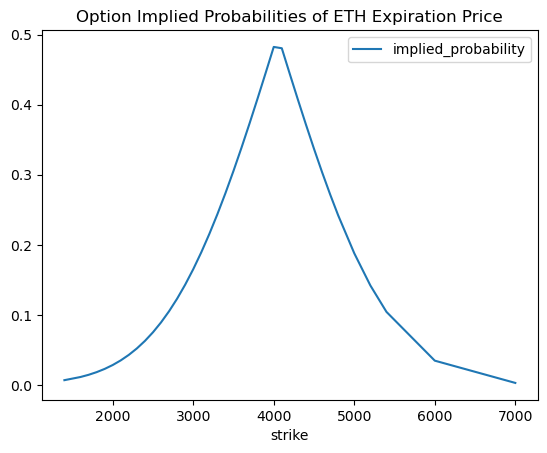

In [32]:
option_chain_full[['strike','implied_probability']].set_index('strike').plot(title='Option Implied Probabilities of ETH Expiration Price')

In [33]:
option_chain_full[['strike','implied_probability']]

,strike,implied_probability
0,1400.0,0.006954
0,1600.0,0.011488
0,1700.0,0.014595
0,1800.0,0.018398
0,1900.0,0.023015
0,2000.0,0.028572
0,2100.0,0.035202
0,2200.0,0.043045
0,2300.0,0.052243
0,2400.0,0.062937


## Vol Skew

<Axes: xlabel='strike'>

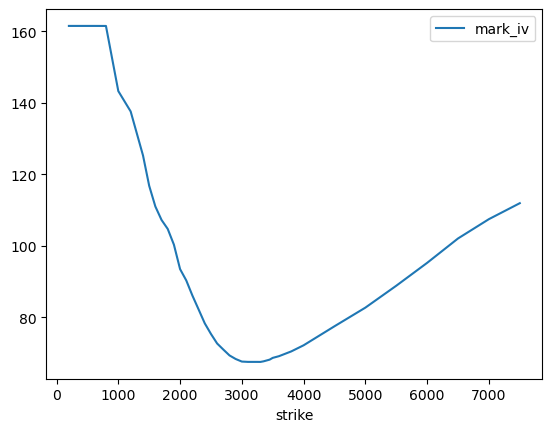

In [23]:
option_chain_full[['strike','mark_iv']].set_index('strike').plot()

## IV Adjusted Premium Calc

In [24]:
option_chain_full['adjusted_iv']=(option_chain_full['mark_iv'])**3
option_chain_full['iv_adjusted_mark_price']=option_chain_full['adjusted_iv']*option_chain_full['mark_price']

<Axes: xlabel='strike'>

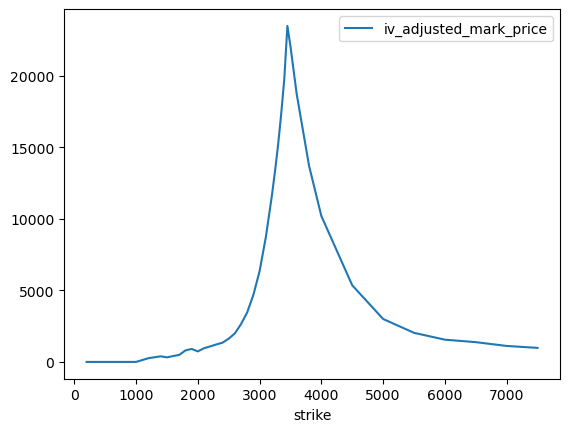

In [25]:
option_chain_full[['strike','iv_adjusted_mark_price']].set_index('strike').plot()

In [26]:
iv_gradient = pd.DataFrame(abs(option_chain_full['mark_iv'].diff()))
iv_gradient.index = option_chain_full['strike']
iv_gradient = iv_gradient[(iv_gradient.index>curr_price - 1000) & (iv_gradient.index<curr_price +1000)]

<Axes: xlabel='strike'>

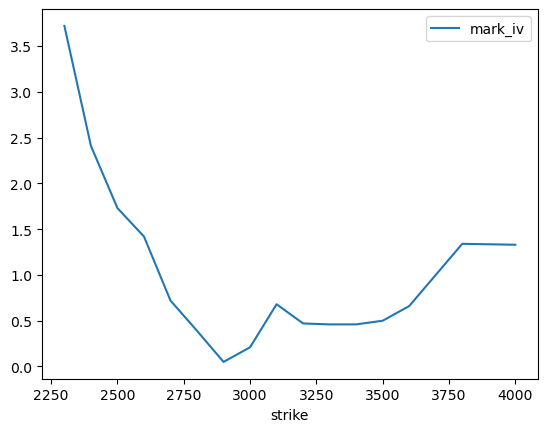

In [213]:
iv_gradient.plot()

# Check for Spot

In [194]:
import pandas as pd
import numpy as np
import nest_asyncio
nest_asyncio.apply()
import account_mgmt as accmgmt
import csv
import os

creds = pd.read_csv(r'C:\Users\kmavy\OneDrive\Desktop\credentials.csv')
#dep = float(input('Enter Deposit Amount:'))
client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = accmgmt.DeribitWS(client_id=client_id, client_secret=client_secret, live=True)
positions = ws.get_positions(currency='ETH')['result']

Authentication success


In [542]:
for i in positions:
    print(i['kind'])

option
option
option
option
option
option
option
option
option
option
option
option


In [592]:
hdata.get_hist_data(start_dt,end_dt,'ETH-PERPETUAL','1D')[['close']].to_csv('eth_index.csv')

In [1]:
import market_data as mktdata
import os

## Test Again

Authentication success
PnL    0.003581
dtype: float64
Position buy ETH-12APR24-2600-P Floating PnL:-52.619011 Posn: buy 2.0
Position sell ETH-12APR24-2800-P Floating PnL:41.311334 Posn: sell -1.0
Position buy ETH-12APR24-2900-P Floating PnL:-8.836408 Posn: buy 1.0
Position sell ETH-12APR24-3000-P Floating PnL:11.704878 Posn: sell -1.0
Position sell ETH-12APR24-3100-P Floating PnL:17.528443 Posn: sell -1.0
Position sell ETH-12APR24-3900-C Floating PnL:-59.349491 Posn: sell -2.0
Position sell ETH-12APR24-4000-C Floating PnL:-19.396532 Posn: sell -1.0
Position buy ETH-12APR24-4100-C Floating PnL:32.747564 Posn: buy 2.0
Position buy ETH-12APR24-4400-C Floating PnL:-14.424021 Posn: buy 1.0
Position buy ETH-26APR24-2700-P Floating PnL:-41.794103 Posn: buy 2.0
Position sell ETH-26APR24-2900-P Floating PnL:63.034855 Posn: sell -2.0
Position sell ETH-26APR24-4600-C Floating PnL:333.210463 Posn: sell -2.0
Position buy ETH-26APR24-4800-C Floating PnL:-290.897766 Posn: buy 2.0
Total Profit:  0.003

C:\Users\kmavy\AppData\Local\Temp\ipykernel_34724\2518377468.py:48: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  shortvolpnl = pd.DataFrame([ret[0]],index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['daily_pnl'])
C:\Users\kmavy\AppData\Local\Temp\ipykernel_34724\2518377468.py:49: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  portfolio_greeks = pd.DataFrame(np.array([delta*10,vega,theta,gamma]).reshape(-1,4),index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['delta10','vega','theta','gamma1000'])
C:\Users\kmavy\AppData\Local\Temp\ipykernel_34724\2518377468.py:61: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end_dt = int(pd.datetime.today().timestamp()*1000)


                 PnL
2024-02-01  0.000000
2024-02-02  0.000000
2024-02-03  0.000000
2024-02-04  0.000000
2024-02-05  0.000000
2024-02-06  0.000000
2024-02-07  0.000000
2024-02-08  0.000000
2024-02-09  0.000000
2024-02-10  0.000000
2024-02-11  0.000000
2024-02-12  0.000000
2024-02-13  0.000000
2024-02-14  0.000000
2024-02-15  0.000000
2024-02-16  0.000000
2024-02-17  0.000000
2024-02-18  0.000000
2024-02-19 -0.014368
2024-02-20  0.001909
2024-02-21 -0.004262
2024-02-22 -0.006865
2024-02-23  0.029847
2024-02-24 -0.005835
2024-02-25 -0.021911
2024-02-26  0.000331
2024-02-27 -0.028583
2024-02-28 -0.038185
2024-02-29 -0.054106
2024-03-01  0.045094
2024-03-02  0.008709
2024-03-03  0.002512
2024-03-04 -0.023085
2024-03-05  0.008009
2024-03-06  0.086911
2024-03-07  0.020598
2024-03-08  0.015867
2024-03-09 -0.014840
2024-03-10  0.011859
2024-03-11 -0.014559
2024-03-12  0.016982
2024-03-13 -0.000395
2024-03-14  0.022058
2024-03-15 -0.005275
2024-03-16  0.011149
2024-03-17 -0.038554
2024-03-18  0

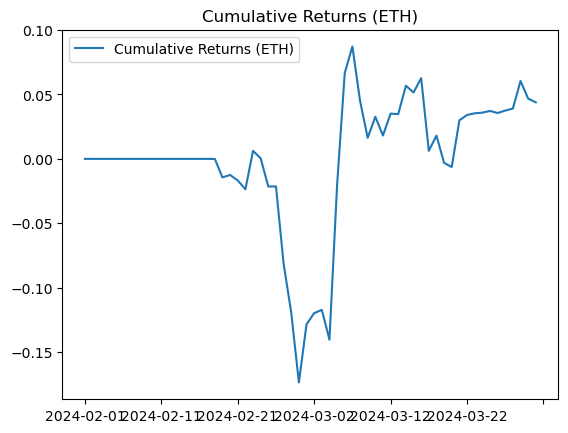

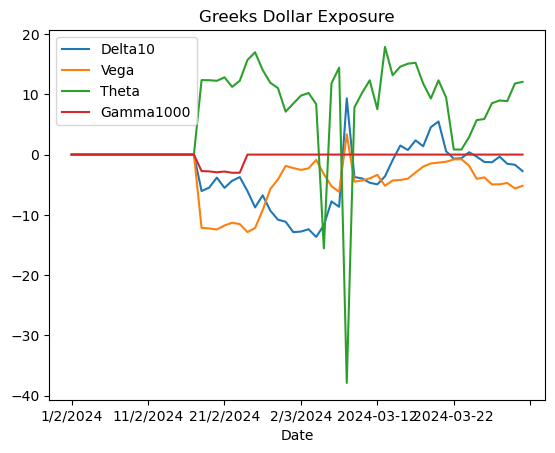

In [2]:
import pandas as pd
import numpy as np
import nest_asyncio
nest_asyncio.apply()
import account_mgmt as accmgmt
import csv
import os

creds = pd.read_csv(r'C:\Users\kmavy\OneDrive\Desktop\credentials.csv')
#dep = float(input('Enter Deposit Amount:'))
client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = accmgmt.DeribitWS(client_id=client_id, client_secret=client_secret, live=True)
positions = ws.get_positions(currency='ETH')['result']
pnl,delta,vega,theta,gamma = 0,0,0,0,0


perf_path =os.path.join(os.getcwd(),'performance_analytics\\floating_rets.csv') 
greeks_path = os.path.join(os.getcwd(),'performance_analytics\\portfolio_greeks.csv') 

rets = pd.read_csv(r'performance_analytics\\floating_rets.csv',index_col = 0)
prev_rets = rets.sum()
print(prev_rets)



c=1
ret=0
for dets in positions:
    print(f"Position {dets['direction']} {dets['instrument_name']} Floating PnL:{dets['floating_profit_loss_usd']} Posn: {dets['direction']} {dets['size']}")
    ret+=(dets['total_profit_loss'])
    delta +=dets['delta']
    theta +=dets['theta']
    vega +=dets['vega']
    gamma+=dets['gamma']
    c+=1
print('Total Profit: ',ret)
ret = ret-prev_rets
print('''


''')



### Get Floating PnL
shortvolpnl = pd.DataFrame([ret[0]],index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['daily_pnl'])
portfolio_greeks = pd.DataFrame(np.array([delta*10,vega,theta,gamma]).reshape(-1,4),index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['delta10','vega','theta','gamma1000'])





rets = pd.read_csv(r'performance_analytics\\floating_rets.csv',index_col = 0)
rets.index = [dt.strftime("%Y-%m-%d") for dt in pd.to_datetime(rets.index)]
rets = rets[~rets.index.duplicated(keep='last')]

### Get Realized PnL
start_dt = int(pd.to_datetime('20240101').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)
trade_log = ws.get_trade_log("ETH",start_dt,end_dt)
realized_pnl = ws.get_agg_rel_pnl(trade_log)
realized_pnl = realized_pnl.sort_index()
rel_pnl_path = os.path.join(os.getcwd(),'performance_analytics\\realized_rets.csv') 
realized_pnl.to_csv(rel_pnl_path)

#Combine Realized and Floating PnL
print(rets,realized_pnl)

rets = pd.concat([rets,realized_pnl[['PnL']].groupby(realized_pnl.index).sum()],axis=1).fillna(0).sum(axis=1)
rets = pd.DataFrame(rets.cumsum(),columns = ['Cumulative Returns (ETH)'])
pic= rets.plot(title = 'Cumulative Returns (ETH)').get_figure()
#pic.savefig('CumulativePerformance.png')

# Get Greeks
greeks = pd.read_csv(r'performance_analytics\\portfolio_greeks.csv',index_col = 0)
greeks= greeks[~greeks.index.duplicated(keep='last')]
pic = greeks.plot(title = 'Greeks Dollar Exposure').get_figure()
#pic.savefig('GreeksExposure.png')

print('Success')

In [27]:
import asyncio
import websockets
import json
import nest_asyncio
import pandas as pd
import numpy as np
import datetime
from concurrent.futures import ThreadPoolExecutor
from functools import partial
nest_asyncio.apply()


class DeribitWS:

    def __init__(self, client_id, client_secret, live=False):

        if not live:
            self.url = 'wss://test.deribit.com/ws/api/v2'
        elif live:
            self.url = 'wss://www.deribit.com/ws/api/v2'
        else:
            raise Exception('live must be a bool, True=real, False=paper')


        self.client_id = client_id
        self.client_secret = client_secret

        self.auth_creds = {
              "jsonrpc" : "2.0",
              "id" : 0,
              "method" : "public/auth",
              "params" : {
                "grant_type" : "client_credentials",
                "client_id" : self.client_id,
                "client_secret" : self.client_secret
              }
            }
        self.test_creds()

        self.msg = {
            "jsonrpc": "2.0",
            "id": 0,
            "method": None,
        }

    async def pub_api(self, msg):
        async with websockets.connect(self.url) as websocket:
            await websocket.send(msg)
            while websocket.open:
                response = await websocket.recv()
                return json.loads(response)

    async def priv_api(self, msg):
        async with websockets.connect(self.url) as websocket:
            await websocket.send(json.dumps(self.auth_creds))
            while websocket.open:
                response = await websocket.recv()
                await websocket.send(msg)
                response = await websocket.recv()
                break
            return json.loads(response)

    @staticmethod
    def async_loop(api, message):
        return asyncio.get_event_loop().run_until_complete(api(message))

    def test_creds(self):
        response = self.async_loop(self.pub_api, json.dumps(self.auth_creds))
        if 'error' in response.keys():
            raise Exception(f"Auth failed with error {response['error']}")
        else:
            print("Authentication success")

    def market_order(self, instrument, amount, direction):
        params = {
                "instrument_name" : instrument,
                "amount" : amount,
                "type" : "market",
              }

        if direction.lower() == 'long':
            side = 'buy'
        elif direction.lower() == 'short':
            side = 'sell'
        else:
            raise ValueError('direction must be long or short')

        self.msg["method"] = f"private/{side}"
        self.msg["params"] = params

        response = self.async_loop(self.priv_api, json.dumps(self.msg))

        return response


    def limit_order(self, instrument, amount, direction, price,
                   post_only, reduce_only):
        params = {
            "instrument_name": instrument,
            "amount": amount,
            "type": "limit",
            "price": price,
            "post_only":  post_only,
            "reduce_only": reduce_only

        }
        if direction.lower() == 'long':
            side = 'buy'
        elif direction.lower() == 'short':
            side = 'sell'
        else:
            raise ValueError('direction must be long or short')

        self.msg["method"] = f"private/{side}"
        self.msg["params"] = params
        response = self.async_loop(self.priv_api, json.dumps(self.msg))
        return response

    # market data methods
    def get_data(self, instrument, start, end, timeframe):
        params =  {
                "instrument_name": instrument,
                "start_timestamp": start,
                "end_timestamp": end,
                "resolution": timeframe
            }

        self.msg["method"] = "public/get_tradingview_chart_data"
        self.msg["params"] = params

        data = self.async_loop(self.pub_api, json.dumps(self.msg))
        return data

    def get_orderbook(self, instrument, depth=5):
        params = {
            "instrument_name": instrument,
            "depth": depth
        }
        self.msg["method"] = "public/get_order_book"
        self.msg["params"] = params

        order_book = self.async_loop(self.pub_api, json.dumps(self.msg))
        return order_book

    def get_quote(self, instrument):
        params = {
            "instrument_name": instrument
        }
        self.msg["method"] = "public/ticker"
        self.msg["params"] = params
        quote = self.async_loop(self.pub_api, json.dumps(self.msg))

        return quote['result']['last_price']

    #account methods
    def account_summary(self, currency, extended=True):
        params = {
            "currency": currency,
            "extended": extended
        }

        self.msg["method"] = "private/get_account_summary"
        self.msg["params"] = params
        summary = self.async_loop(self.priv_api, json.dumps(self.msg))
        return summary

    def get_positions(self, currency, kind="option"):
        params = {
            "currency": currency,
            "kind": kind
        }
        self.msg["method"] = "private/get_positions"
        self.msg["params"] = params
        positions = self.async_loop(self.priv_api, json.dumps(self.msg))
        return positions
    

    def available_instruments(self, currency, kind="future", expired=False):
        params = {
            "currency": currency,
            "kind": kind,
            "expired": expired
        }

        self.msg["method"] = "public/get_instruments"
        self.msg["params"] = params
        resp = self.async_loop(self.pub_api, json.dumps(self.msg))
        instruments = [d["instrument_name"] for d in resp['result']]
        return instruments
    


#    def get_trade_hist(self,currency,count = 10):
#        params={
#            'currency':currency,
#            'count':count
#        }
#        self.msg['method'] = "private/get_trigger_order_history"
#        self.msg['params']=params
#        resp = self.async_loop(self.priv_api, json.dumps(self.msg))
#        return resp

    def get_trade_hist(self,currency,start,end):
        params={
            'currency':currency,
            'start_timestamp':start,
            'end_timestamp':end
        }
        self.msg['method'] = "private/get_transaction_log"
        self.msg['params']=params
        resp = self.async_loop(self.priv_api, json.dumps(self.msg))

        return resp
    
    def get_trade_log(self,currency,start,end):
        log = self.get_trade_hist(currency,start,end)
        logs = pd.DataFrame()
        ttd_instrument_hist = []
        for i in range(len(log['result']['logs'])):
            instrument = log['result']['logs'][i]['instrument_name']
            ttd_instrument_hist.append(instrument)
            #if instrument =="ETH-8MAR24-3600-C" or instrument =='ETH-8MAR':
            temp = pd.DataFrame(log['result']['logs'][i].values(),index =log['result']['logs'][i].keys())
            logs = pd.concat([logs,temp],axis=1)
        trade_log = logs.T
        trade_log.index = range(len(trade_log))
        trade_log['datetime'] = [datetime.datetime.fromtimestamp(int(str(dt)[:-3])) for dt in trade_log.timestamp]
        trade_log['Date'] = [dt.strftime("%Y-%m-%d") for dt in trade_log.datetime]
        trade_log['side']=trade_log['side'].replace('-',"N.A. N.A.")
        dirlist = []
        for side in trade_log['side']:
            try:
                dirlist.append(side.split(" ")[1])
            except:
                dirlist.append('None')
        trade_log['direction'] = dirlist
        trade_log['direction'] = [1 if direction =='buy' else -1 if direction =='sell' else 0 for direction in trade_log.direction]
        trade_log['trade_type'] = [side.split(" ")[0] for side in trade_log.side]
        return trade_log
    
    def get_realized_pnl(self,trade_log,instrument):
        def net_closing_px(exits):
            weighted_exit = sum(exits['amount']*exits['price'])/sum(exits['amount'])
            return weighted_exit
        
        trade_log = trade_log[trade_log['instrument_name']==instrument]
        realized_position = sum((trade_log['direction']*trade_log['amount']).dropna())
        entries = trade_log[trade_log['trade_type']=='open']
        exits = trade_log[(trade_log['trade_type']=='close')|(trade_log['trade_type']=='liquidation')]
        if exits.empty or entries.empty:
            return pd.DataFrame()
        weighted_entry = (sum(entries['amount']*entries['price']))/abs(sum(entries['amount']))
        weighted_exits = exits.groupby('Date').apply(net_closing_px)
        weighted_exits = pd.DataFrame(weighted_exits,columns = ['PnL'])

        #entry_volume = abs(sum(entries['amount']))
        exit_volume = -sum(exits['amount']*exits['direction'])

        realized_volume = exit_volume
        realized_pnl = (weighted_exits - weighted_entry)*realized_volume
        realized_pnl['instrument']=[instrument]*len(realized_pnl)
        realized_pnl['traded_volume'] = realized_volume
        realized_pnl['weighted_avg_entry'] = weighted_entry
        realized_pnl['weighted_avg_exit'] = weighted_exits
        #realized_pnl = (weighted_exit - weighted_entry)/abs(realized_position)
        #print(weighted_entry,weighted_exit,realized_position)
        return realized_pnl

    
    def get_agg_rel_pnl(self,trade_log):
        pool = ThreadPoolExecutor(max_workers = 20)
        RealizedPnL = pd.DataFrame()
        agg_rel_pnl_func = partial(self.get_realized_pnl,trade_log)
        ttd_instruments = set(trade_log.instrument_name)
        for data in pool.map(agg_rel_pnl_func,ttd_instruments):
            RealizedPnL = pd.concat([RealizedPnL,data],axis=0)
        RealizedPnL['type'] = [len(i.split("-")) for i in RealizedPnL['instrument']]
        RealizedPnL['type'] = ['option' if i==4 else 'future' if i==2 else 'spot' if i==1 else "unknown" for i in RealizedPnL['type']]
        return RealizedPnL


In [ ]:
ws.get_trade_hist("ETH",)

In [ ]:
Buy 3x at 

In [49]:
0.084/3

0.028

In [48]:
0.0105/3

0.0035

In [47]:
trade_log[trade_log['instrument_name']=='ETH-8MAR24-3800-C']

,profit_as_cashflow,price_currency,side,user_role,trade_id,interest_pl,contracts,user_seq,equity,fee_balance,...,info,id,session_upl,session_rpl,total_interest_pl,role,datetime,Date,direction,trade_type
58,False,ETH,close sell,maker,ETH-196761268,0.0,3.0,1709648826572862,0.242709,0.0,...,Source: web,410500365,NaN,NaN,NaN,NaN,2024-03-05 22:27:06,2024-03-05,-1,close
87,False,ETH,open buy,taker,ETH-195087246,0.0,2.0,1708964309082403,0.539031,0.0,...,Source: web,406994043,NaN,NaN,NaN,NaN,2024-02-27 00:18:29,2024-02-27,1,open
88,False,ETH,open buy,maker,ETH-194920931,0.0,1.0,1708884142745381,0.562658,0.0,...,Source: web,406646135,NaN,NaN,NaN,NaN,2024-02-26 02:02:22,2024-02-26,1,open


In [41]:
ws.get_realized_pnl(trade_log,'ETH-8MAR24-3800-C')

,PnL,instrument,traded_volume,weighted_avg_entry,weighted_avg_exit
Date,,,,,
2024-03-05,0.0735,ETH-8MAR24-3800-C,3.0,0.0035,0.028


In [28]:
client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = DeribitWS(client_id=client_id, client_secret=client_secret, live=True)

Authentication success


In [29]:
ws.get_agg_rel_pnl(trade_log)

,PnL,instrument,traded_volume,weighted_avg_entry,weighted_avg_exit,type
Date,,,,,,
2024-03-22,-0.00600,ETH-22MAR24-3100-P,2.0,0.003000,0.00000,option
2024-03-17,-0.01000,ETH-22MAR24-3200-P,-2.0,0.003500,0.00850,option
2024-03-17,-0.01500,ETH-29MAR24-2800-P,5.0,0.009000,0.00600,option
2024-03-22,-0.05750,ETH-22MAR24-4800-C,6.0,0.009583,0.00000,option
2024-03-17,0.00600,ETH-29MAR24-3000-P,-4.0,0.015500,0.01400,option
2024-03-29,0.00750,ETH-12APR24-4200-C,-1.0,0.015500,0.00800,option
2024-03-08,-0.00450,ETH-8MAR24-2200-P,3.0,0.001500,0.00000,option
2024-02-27,-0.03400,ETH-8MAR24-3300-C,-2.0,0.009500,0.02650,option
2024-03-29,0.01000,ETH-12APR24-2800-P,-1.0,0.016000,0.00600,option


In [ ]:
ws

In [7]:
trade_log = ws.get_trade_log("ETH",start_dt,end_dt)
realized_pnl = ws.get_agg_rel_pnl(trade_log)
realized_pnl = realized_pnl.sort_index()

In [14]:
realized_pnl

,PnL,instrument,type
Date,,,
2024-02-26,-0.00018,ETH-8MAR24-3600-C,option
2024-02-27,0.00272,ETH-8MAR24-3600-C,option
2024-02-27,-0.03400,ETH-8MAR24-3300-C,option
2024-03-05,0.05847,ETH-8MAR24-3600-C,option
2024-03-05,0.07350,ETH-8MAR24-3800-C,option
2024-03-05,-0.07800,ETH-29MAR24-3400-C,option
2024-03-05,0.05800,ETH-29MAR24-3600-C,option
2024-03-08,-0.06840,ETH-15MAR24-4000-C,option
2024-03-08,-0.00450,ETH-8MAR24-2200-P,option


C:\Users\kmavy\AppData\Local\Temp\ipykernel_34724\3352655025.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  realized_pnl.groupby('Date').sum().cumsum().plot()


<Axes: xlabel='Date'>

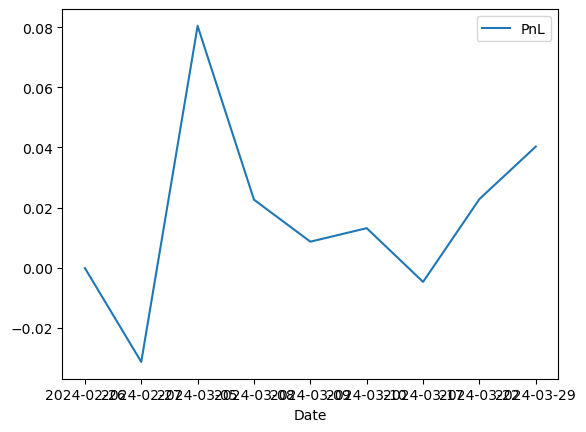

In [6]:
realized_pnl.groupby('Date').sum().cumsum().plot()

In [293]:
start = int(pd.to_datetime('20221231').timestamp()*1000)
end = int(pd.datetime.today().timestamp()*1000)
timeframe = '1D'

# Update PnL Tracker

In [203]:
import pandas as pd
import numpy as np
import nest_asyncio
nest_asyncio.apply()
import account_mgmt as accmgmt
import csv
import os

creds = pd.read_csv(r'C:\Users\kmavy\OneDrive\Desktop\credentials.csv')
#dep = float(input('Enter Deposit Amount:'))
client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = accmgmt.DeribitWS(client_id=client_id, client_secret=client_secret, live=True)
positions = ws.get_positions(currency='ETH')['result']
pnl,delta,vega,theta,gamma = 0,0,0,0,0


perf_path =os.path.join(os.getcwd(),'performance_analytics\\floating_rets.csv') 
greeks_path = os.path.join(os.getcwd(),'performance_analytics\\portfolio_greeks.csv') 

rets = pd.read_csv(r'performance_analytics\\floating_rets.csv',index_col = 0)
prev_rets = rets.sum()
print(prev_rets)



c=1
ret=0
for dets in positions:
    print(f"Position {dets['direction']} {dets['instrument_name']} Floating PnL:{dets['floating_profit_loss_usd']} Posn: {dets['direction']} {dets['size']}")
    ret+=(dets['total_profit_loss'])
    delta +=dets['delta']
    theta +=dets['theta']
    vega +=dets['vega']
    gamma+=dets['gamma']
    c+=1
print('Total Profit: ',ret)
ret = prev_rets+ret
print('''


''')



### Get Floating PnL
shortvolpnl = pd.DataFrame([ret[0]],index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['daily_pnl'])
portfolio_greeks = pd.DataFrame(np.array([delta*10,vega,theta,gamma]).reshape(-1,4),index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['delta10','vega','theta','gamma1000'])

with open(perf_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(shortvolpnl)):
        temp = shortvolpnl.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()



with open(greeks_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(portfolio_greeks)):
        temp = portfolio_greeks.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()





rets = pd.read_csv(r'performance_analytics\\floating_rets.csv',index_col = 0)
rets.index = [dt.strftime("%Y-%m-%d") for dt in pd.to_datetime(rets.index)]
rets = rets[~rets.index.duplicated(keep='last')]

### Get Realized PnL
start_dt = int(pd.to_datetime('20240101').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)
trade_log = ws.get_trade_log("ETH",start_dt,end_dt)
realized_pnl = ws.get_agg_rel_pnl(trade_log)
realized_pnl = realized_pnl.sort_index()
rel_pnl_path = os.path.join(os.getcwd(),'performance_analytics\\realized_rets.csv') 
realized_pnl.to_csv(rel_pnl_path)

#Combine Realized and Floating PnL

rets = pd.concat([rets,realized_pnl[['PnL']].groupby(realized_pnl.index).sum()],axis=1).fillna(0).sum(axis=1)
rets = pd.DataFrame(rets.cumsum(),columns = ['Cumulative Returns (ETH)'])
pic= rets.plot(title = 'Cumulative Returns (ETH)').get_figure()
pic.savefig('CumulativePerformance.png')

# Get Greeks
greeks = pd.read_csv(r'performance_analytics\\portfolio_greeks.csv',index_col = 0)
greeks= greeks[~greeks.index.duplicated(keep='last')]
pic = greeks.plot(title = 'Greeks Dollar Exposure').get_figure()
pic.savefig('GreeksExposure.png')


Authentication success
PnL   -0.013877
dtype: float64
Position sell ETH-15MAR24-4000-C Floating PnL:-151.255088 Posn: sell -4.0
Position buy ETH-15MAR24-4200-C Floating PnL:72.280094 Posn: buy 4.0
Position sell ETH-29MAR24-2500-P Floating PnL:42.152794 Posn: sell -1.0
Position buy ETH-29MAR24-2800-P Floating PnL:-40.257596 Posn: buy 5.0
Position sell ETH-29MAR24-3000-P Floating PnL:64.280395 Posn: sell -4.0
Position sell ETH-29MAR24-4500-C Floating PnL:-140.669735 Posn: sell -3.0
Position buy ETH-29MAR24-5000-C Floating PnL:65.125139 Posn: buy 3.0
Position buy ETH-8MAR24-2200-P Floating PnL:-13.14548 Posn: buy 3.0
Position sell ETH-8MAR24-2500-P Floating PnL:50.471399 Posn: sell -3.0
Total Profit:  -0.0017725359999999947






TypeError: cannot concatenate object of type '<class 'tuple'>'; only Series and DataFrame objs are valid

In [526]:
rets

,PnL
Date,
1/2/2024,0.000000
2/2/2024,0.000000
3/2/2024,0.000000
4/2/2024,0.000000
5/2/2024,0.000000
6/2/2024,0.000000
7/2/2024,0.000000
8/2/2024,0.000000
9/2/2024,0.000000



with open(perf_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(shortvolpnl)):
        temp = shortvolpnl.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()



with open(greeks_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(portfolio_greeks)):
        temp = portfolio_greeks.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()


In [524]:
rets

,PnL
2024-01-02,0.000000
2024-02-02,0.000000
2024-03-02,0.000000
2024-04-02,0.000000
2024-05-02,0.000000
2024-06-02,0.000000
2024-07-02,0.000000
2024-08-02,0.000000
2024-09-02,0.000000
2024-10-02,0.000000


In [514]:
import pandas as pd
import numpy as np
import nest_asyncio
nest_asyncio.apply()
import account_mgmt as accmgmt
import csv
import os

creds = pd.read_csv(r'C:\Users\kmavy\OneDrive\Desktop\credentials.csv')
#dep = float(input('Enter Deposit Amount:'))
client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = accmgmt.DeribitWS(client_id=client_id, client_secret=client_secret, live=True)
positions = ws.get_positions(currency='ETH')['result']
pnl,delta,vega,theta,gamma = 0,0,0,0,0


perf_path =os.path.join(os.getcwd(),'performance_analytics\\floating_rets.csv') 
greeks_path = os.path.join(os.getcwd(),'performance_analytics\\portfolio_greeks.csv') 

rets = pd.read_csv(r'performance_analytics\\floating_rets.csv',index_col = 0)
prev_rets = rets.sum()
print(prev_rets)



c=1
ret=0
for dets in positions:
    print(f"Position {dets['direction']} {dets['instrument_name']} Floating PnL:{dets['floating_profit_loss_usd']} Posn: {dets['direction']} {dets['size']}")
    ret+=(dets['total_profit_loss'])
    delta +=dets['delta']
    theta +=dets['theta']
    vega +=dets['vega']
    gamma+=dets['gamma']
    c+=1
print('Total Profit: ',ret)
ret = ret-prev_rets
print('''


''')



### Get Floating PnL
shortvolpnl = pd.DataFrame([ret[0]],index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['daily_pnl'])
portfolio_greeks = pd.DataFrame(np.array([delta*10,vega,theta,gamma]).reshape(-1,4),index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['delta10','vega','theta','gamma1000'])

with open(perf_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(shortvolpnl)):
        temp = shortvolpnl.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()



with open(greeks_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(portfolio_greeks)):
        temp = portfolio_greeks.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()





rets = pd.read_csv(r'performance_analytics\\floating_rets.csv',index_col = 0)
rets = rets[~rets.index.duplicated(keep='last')]

### Get Realized PnL
start_dt = int(pd.to_datetime('20240101').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)
trade_log = ws.get_trade_log("ETH",start_dt,end_dt)
realized_pnl = ws.get_agg_rel_pnl(trade_log)
realized_pnl = realized_pnl.sort_index()
rel_pnl_path = os.path.join(os.getcwd(),'performance_analytics\\realized_rets.csv') 
realized_pnl.to_csv(rel_pnl_path)

#Combine Realized and Floating PnL
rets.index = [dt.strftime("%Y-%m-%d") for dt in pd.to_datetime(rets.index)]
rets = pd.concat([rets,realized_pnl[['PnL']].groupby(realized_pnl.index).sum()],axis=1).fillna(0).sum(axis=1)
rets = pd.DataFrame(rets.cumsum(),columns = ['Cumulative Returns (ETH)'])
pic= rets.plot(title = 'Cumulative Returns (ETH)').get_figure()
pic.savefig('CumulativePerformance.png')

# Get Greeks
greeks = pd.read_csv(r'performance_analytics\\portfolio_greeks.csv',index_col = 0)
greeks= greeks[~greeks.index.duplicated(keep='last')]
pic = greeks.plot(title = 'Greeks Dollar Exposure').get_figure()
pic.savefig('GreeksExposure.png')


Authentication success
PnL   -0.074702
dtype: float64
Position buy ETH-29MAR24-2100-P Floating PnL:-46.655192 Posn: buy 4.0
Position sell ETH-29MAR24-2300-P Floating PnL:97.143051 Posn: sell -4.0
Position sell ETH-29MAR24-2500-P Floating PnL:41.075523 Posn: sell -1.0
Position sell ETH-29MAR24-3300-C Floating PnL:-1000.945811 Posn: sell -4.0
Position sell ETH-29MAR24-3400-C Floating PnL:-184.546975 Posn: sell -1.0
Position buy ETH-29MAR24-3500-C Floating PnL:722.157037 Posn: buy 4.0
Position buy ETH-29MAR24-3600-C Floating PnL:129.256141 Posn: buy 1.0
Position buy ETH-8MAR24-2200-P Floating PnL:-13.095857 Posn: buy 3.0
Position sell ETH-8MAR24-2500-P Floating PnL:48.932701 Posn: sell -3.0
Position sell ETH-8MAR24-3400-C Floating PnL:-97.829103 Posn: sell -1.0
Position sell ETH-8MAR24-3600-C Floating PnL:-72.528678 Posn: sell -2.0
Position buy ETH-8MAR24-3800-C Floating PnL:52.56184 Posn: buy 3.0
Total Profit:  -0.07500220200000006






InvalidIndexError: Reindexing only valid with uniquely valued Index objects

# Offline

In [3]:
import os
import pandas as pd
os.getcwd()

'c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility'

In [263]:
0.1*(-160)+(0.1*-60)+0.6*80+0.1*(-160)+0.1*(-60)

4.0

In [245]:
import pandas as pd
import numpy as np
import nest_asyncio
nest_asyncio.apply()
import account_mgmt as accmgmt
import csv
import os

creds = pd.read_csv(r'C:\Users\kmavy\OneDrive\Desktop\credentials.csv')

client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = accmgmt.DeribitWS(client_id=client_id, client_secret=client_secret, live=True)
positions = ws.get_positions(currency='ETH')['result']
pnl,delta,vega,theta,gamma = 0,0,0,0,0


perf_path =os.path.join(os.getcwd(),'performance_analytics\\perf_analytics.csv') 
greeks_path = os.path.join(os.getcwd(),'performance_analytics\\portfolio_greeks.csv') 

rets = pd.read_csv(r'performance_analytics\\perf_analytics.csv',index_col = 0)
prev_rets = (1+rets).prod()-1
print(prev_rets)
dep = float(input('Enter Deposit Amount:'))
c=1
ret=0
for dets in positions:
    print(f"Position {dets['direction']} {dets['instrument_name']} PnL:{dets['floating_profit_loss_usd']} Posn: {dets['direction']} {dets['size']}")
    ret+=(dets['floating_profit_loss_usd']+dets['realized_profit_loss'])
    delta +=dets['delta']
    theta +=dets['theta']
    vega +=dets['vega']
    gamma+=dets['gamma']
    c+=1
print('Total Profit: ',ret)
ret = ret/dep
ret = ((1+ret)/(1+prev_rets))-1
print('''


''')

Authentication success
PnL   -0.141668
dtype: float64
Position buy ETH-29MAR24-2100-P PnL:-45.581751 Posn: buy 4.0
Position sell ETH-29MAR24-2300-P PnL:96.602266 Posn: sell -4.0
Position sell ETH-29MAR24-2500-P PnL:41.377901 Posn: sell -1.0
Position sell ETH-29MAR24-3300-C PnL:-941.965063 Posn: sell -4.0
Position sell ETH-29MAR24-3400-C PnL:-171.245835 Posn: sell -1.0
Position buy ETH-29MAR24-3500-C PnL:670.933411 Posn: buy 4.0
Position buy ETH-29MAR24-3600-C PnL:117.297127 Posn: buy 1.0
Position buy ETH-8MAR24-2200-P PnL:-13.072412 Posn: buy 3.0
Position sell ETH-8MAR24-2500-P PnL:49.331745 Posn: sell -3.0
Position sell ETH-8MAR24-3400-C PnL:-82.438292 Posn: sell -1.0
Position sell ETH-8MAR24-3600-C PnL:-52.121715 Posn: sell -2.0
Position buy ETH-8MAR24-3800-C PnL:37.684643 Posn: buy 3.0
Total Profit:  -293.19797500000004






In [216]:

import pandas as pd
import datetime as dt
import datetime
import csv

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

import os

eth_opt = Options('ETH')
btc_opt = Options('BTC')
eth_hdata = HistData('ETH')
btc_hdata = HistData('BTC')

btc_spot = btc_hdata.get_idx_price()
eth_spot = eth_hdata.get_idx_price()

ethpath =os.path.join(os.getcwd(),'data/eth_hist_option_chain.csv') 
btcpath =os.path.join(os.getcwd(),'data/btc_hist_option_chain.csv')


#btc_options = btc_opt.get_full_option_chain(btc_spot)
eth_options = eth_opt.get_full_option_chain(eth_spot)


952 active options.
952 active options.
1710057600000
Expiration Date:  2024-03-11 16:00:00
952 active options.
1735286400000
2024-12-27 08:00:00 date options failed
952 active options.
1714118400000
Expiration Date:  2024-05-31 16:00:00
952 active options.
1717142400000
Expiration Date:  2024-06-28 16:00:00
952 active options.
1711699200000
Expiration Date:  2024-04-26 16:00:00
952 active options.
1711094400000
Expiration Date:  2024-03-29 16:00:00
952 active options.
1709971200000
Expiration Date:  2024-03-10 16:00:00
952 active options.
1710489600000
Expiration Date:  2024-03-22 16:00:00
952 active options.
1719561600000
Expiration Date:  2024-09-27 16:00:00
952 active options.
1727424000000
Expiration Date:  2024-12-27 16:00:00
952 active options.
952 active options.
1710057600000
Expiration Date:  2024-03-11 16:00:00
952 active options.
1735286400000
2024-12-27 08:00:00 date options failed
952 active options.
1714118400000
Expiration Date:  2024-05-31 16:00:00
952 active options.


In [215]:
with open(btcpath,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(btc_options)):
        temp = btc_options.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()

In [213]:
btc_options

,best_bid_amount,best_ask_amount,estimated_delivery_price,bid_iv,ask_iv,underlying_index,underlying_price,mark_iv,best_bid_price,best_ask_price,...,strike,expiration_date,dte,spot,option_type,mid_price,mark_price_usd,mid_price_usd,time,settlement_price
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-09,0.0,0.0,68375.42,0.00,0.00,SYN.BTC-10MAR24,68416.3997,110.30,0.0000,0.0000,...,59000.0,2024-03-10 16:00:00,1,68382.47,call,0.00000,9423.104366,0.000000,13:11:01.168513,0.127262
2024-03-09,0.0,0.1,68375.42,0.00,350.96,SYN.BTC-10MAR24,68416.3997,95.34,0.0000,0.1500,...,60000.0,2024-03-10 16:00:00,1,68382.47,call,0.07500,8417.882057,5128.685250,13:11:01.168513,0.112614
2024-03-09,0.0,0.0,68375.42,0.00,0.00,SYN.BTC-10MAR24,68416.3997,84.68,0.0000,0.0000,...,61000.0,2024-03-10 16:00:00,1,68382.47,call,0.00000,7419.497995,0.000000,13:11:01.168513,0.097981
2024-03-09,0.0,0.0,68375.42,0.00,0.00,SYN.BTC-10MAR24,68416.3997,83.01,0.0000,0.0000,...,61500.0,2024-03-10 16:00:00,1,68382.47,call,0.00000,6920.305964,0.000000,13:11:01.168513,0.090746
2024-03-09,0.0,0.0,68375.42,0.00,0.00,SYN.BTC-10MAR24,68416.3997,77.82,0.0000,0.0000,...,62000.0,2024-03-10 16:00:00,1,68382.47,call,0.00000,6421.113933,0.000000,13:11:01.168513,0.083556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-09,12.0,0.5,68375.41,73.47,75.61,BTC-27DEC24,76421.8500,75.29,0.0835,0.0900,...,140000.0,2024-12-27 16:00:00,293,68382.47,put,0.08675,6086.039830,5932.179272,13:12:26.006689,0.086952
2024-03-09,6.0,1.0,68375.41,74.67,77.07,BTC-27DEC24,76421.8500,75.87,0.0635,0.0700,...,160000.0,2024-12-27 16:00:00,293,68382.47,put,0.06675,4561.110749,4564.529873,13:12:26.006689,0.066305
2024-03-09,13.0,13.3,68375.41,75.36,79.71,BTC-27DEC24,76421.7300,77.51,0.0485,0.0590,...,180000.0,2024-12-27 16:00:00,293,68382.47,put,0.05375,3665.300392,3675.557763,13:12:26.006689,0.053005


# Trade Log Function

In [197]:
start_dt = int(pd.to_datetime('20240101').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)


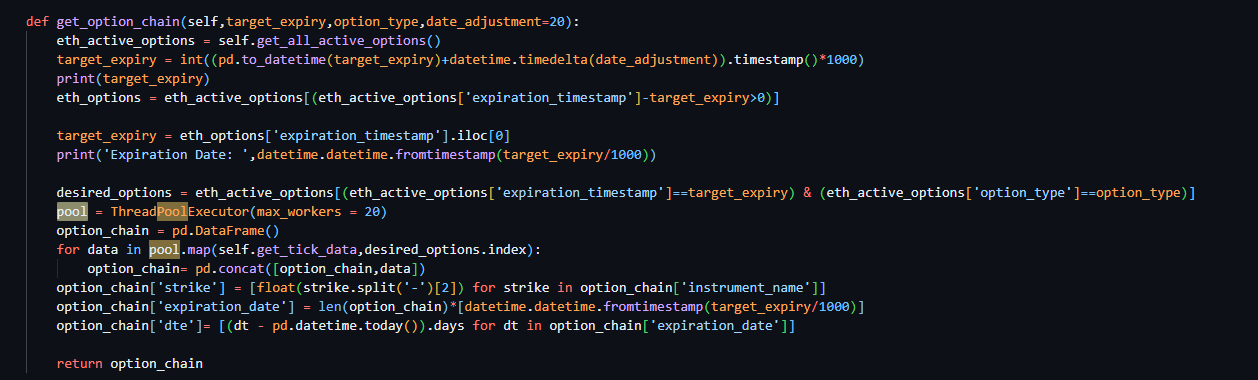
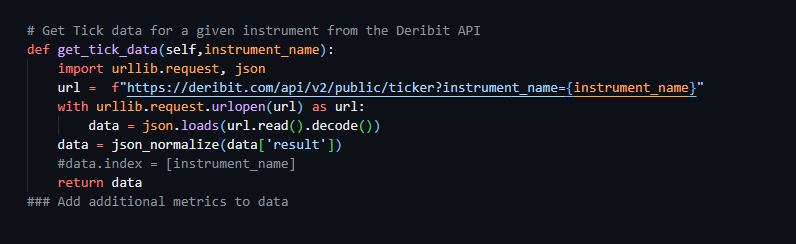

In [204]:
trade_log = ws.get_trade_log("ETH",start_dt,end_dt)

In [205]:
a,b = ws.get_realized_pnl(trade_log,"ETH-8MAR24-3800-C")

In [210]:
a['price']

32     0.004
33    0.0025
Name: price, dtype: object

In [211]:
b['price']

3    0.028
Name: price, dtype: object

In [199]:
ent,ex= get_realized_pnl(trade_log,"ETH-8MAR24-3800-C")

In [190]:
ent,ex = get_realized_pnl(trade_log,'ETH-8MAR24-3800-C')

In [191]:
ent

,profit_as_cashflow,price_currency,side,user_role,trade_id,interest_pl,contracts,user_seq,equity,fee_balance,...,position,info,id,session_rpl,total_interest_pl,role,datetime,Date,direction,trade_type
25,False,ETH,open buy,taker,ETH-195087246,0.0,2.0,1708964309082403,0.539031,0.0,...,3.0,Source: web,406994043,NaN,NaN,NaN,2024-02-27 00:18:29,2024-02-27,1,open
26,False,ETH,open buy,maker,ETH-194920931,0.0,1.0,1708884142745381,0.562658,0.0,...,1.0,Source: web,406646135,NaN,NaN,NaN,2024-02-26 02:02:22,2024-02-26,1,open


In [192]:
ex

,profit_as_cashflow,price_currency,side,user_role,trade_id,interest_pl,contracts,user_seq,equity,fee_balance,...,position,info,id,session_rpl,total_interest_pl,role,datetime,Date,direction,trade_type


In [173]:
trade_log[trade_log['instrument_name']=='ETH-29MAR24-3500-C'][['price','side','direction','contracts','amount','instrument_name']]

,price,side,direction,contracts,amount,instrument_name
10,0.0945,liquidation sell,-1,4.0,4.0,ETH-29MAR24-3500-C
42,0.02,open buy,1,2.0,2.0,ETH-29MAR24-3500-C
46,0.0205,open buy,1,2.0,2.0,ETH-29MAR24-3500-C


In [61]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial

def get_agg_rel_pnl(trade_log):
    pool = ThreadPoolExecutor(max_workers = 20)
    RealizedPnL = pd.DataFrame()
    agg_rel_pnl_func = partial(get_realized_pnl,trade_log)
    ttd_instruments = set(trade_log.instrument_name)
    for data in pool.map(agg_rel_pnl_func,ttd_instruments):
        RealizedPnL = pd.concat([RealizedPnL,data],axis=0)
    RealizedPnL['type'] = [len(i.split("-")) for i in Realized_PnL['instrument']]
    RealizedPnL['type'] = ['option' if i==4 else 'future' if i==2 else 'spot' if i==1 else "unknown"]
    return RealizedPnL

RealizedPnL
    

NameError: name 'RealizedPnL' is not defined

In [111]:
trade_log.columns

Index(['profit_as_cashflow', 'price_currency', 'side', 'user_role', 'trade_id',
       'interest_pl', 'contracts', 'user_seq', 'equity', 'fee_balance',
       'instrument_name', 'order_id', 'username', 'mark_price', 'user_id',
       'amount', 'index_price', 'cashflow', 'commission', 'price', 'change',
       'currency', 'balance', 'type', 'timestamp', 'position', 'info', 'id',
       'datetime', 'Date', 'direction'],
      dtype='object')

In [119]:
trade_log[trade_log['instrument_name']=="ETH-8MAR24-3600-C"][['instrument_name','side','price_currency','profit_as_cashflow','trade_type','commission','price','contracts','amount','direction','datetime','trade_id','Date']]

,instrument_name,side,price_currency,profit_as_cashflow,trade_type,commission,price,contracts,amount,direction,datetime,trade_id,Date
0,ETH-8MAR24-3600-C,open sell,ETH,False,open,0.0003,0.008,1.0,1.0,-1,2024-02-27 00:25:36,ETH-195089436,2024-02-27
1,ETH-8MAR24-3600-C,open sell,ETH,False,open,0.0003,0.008,1.0,1.0,-1,2024-02-27 00:25:36,ETH-195089435,2024-02-27
2,ETH-8MAR24-3600-C,close sell,ETH,False,close,0.0006,0.0075,2.0,2.0,-1,2024-02-27 00:24:45,ETH-195089153,2024-02-27
6,ETH-8MAR24-3600-C,close sell,ETH,False,close,0.0003,0.0046,1.0,1.0,-1,2024-02-26 01:14:42,ETH-194918236,2024-02-26
9,ETH-8MAR24-3600-C,open buy,ETH,False,open,0.0003,0.0027,1.0,1.0,1,2024-02-24 02:16:06,ETH-194754812,2024-02-24
14,ETH-8MAR24-3600-C,open buy,ETH,False,open,0.0006,0.0026,2.0,2.0,1,2024-02-24 00:31:31,ETH-194746322,2024-02-24
